In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CAVEAT

THIS NOTEBOOK IS JUST AN EXAMPLE OF CURVE FITTING ON SOME REAL WORD DATA.

PLEASE REFRAIN TO TAKE ANY DECISION OR TO EXTRAPOLATE ANY RECOMMANDATION BASED ON THIS NOTEBOOK.

**PLEASE STICK TO OFFICIAL RECOMMENDATION AND INFORMATION!**

* https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Load the data provided by JHU 

In [2]:
# Data source: https://github.com/CSSEGISandData/COVID-19
!cd DATA && git pull && cd ../

Already up to date.


In [3]:
df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

#df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [4]:
# Drop data from 2020-03-12 because for many country data for this day was a replica from the previous day.
df_confirmed.drop(columns=['3/12/20'], inplace=True)

In [5]:
# Pivot the data: wide to long
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Models and other amenities

In [6]:
# Exponential model
def exponential_model(x, *pars): 
    return pars[0]+np.exp(pars[1]*x+pars[2])
    
# Logistic model
def logistic_model(x, *pars): 
    return pars[0]+pars[1]/(1+np.exp(-pars[2]*(x-pars[3])))

def fit_model(xdata, ydata, model, p0=[1,1,1]):

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,
                                          p0=p0, 
                                          method='trf',
                                          sigma=np.sqrt(ydata),
                                          absolute_sigma=False,
                                          max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / np.var(ydata)
    
    return popt, pcov, r_square

def model_error(xdata, model, pars, cov):
    
    func = lambda pars, args : model(args, *pars)

    eps = np.finfo(np.float16).eps

    err = []
    for x in xdata:
        g = scipy.optimize.approx_fprime(pars, func, eps, x)
        e = np.sqrt(np.dot(g, np.dot(cov,g.T)))
        err.append(e)
        #print(x,popt,g,e)
    
    err=np.array(err)
    return err

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Parameter errors:')
    print(np.sqrt(np.diag(pcov)))
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)

def forecast(start_date, start_day, n_days, model, popt, pcov):
    
    index = np.arange(start_day, start_day+n_days)
    
    #perr = np.sqrt(np.diag(pcov))
    
    forecast = model(index, *popt)
    error = model_error(index, model, popt, pcov)

    df = pd.DataFrame(
        index=index,
        data={
            'Date': pd.date_range(start=start_date, periods=n_days),
            'Forecast' : forecast,
            '1s_sup' : forecast+error,
            '1s_inf' : forecast-error,
            '2s_sup' : forecast+2*error,
            '2s_inf' : forecast-2*error,
            #'Forecast_sup' : model(index, *(popt+perr)),
            #'Forecast_inf' : model(index, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df
    
def predict(dates, days, model, popt, pcov):
    
    #perr = np.sqrt(np.diag(pcov))
    
    pred = model(days, *popt)
    error = model_error(days, model, popt, pcov)

    
    df = pd.DataFrame(
        data={
            'Date': dates,
            'Model' : pred,
            '1s_sup' : pred+error,
            '1s_inf' : pred-error,
            '2s_sup' : pred+2*error,
            '2s_inf' : pred-2*error,
            #'Model_sup' : model(days, *(popt+perr)),
            #'Model_inf' : model(days, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df

def plot_model(df_prediction, df_forecast, label='', ax=None, **kwargs):
    # Create axis if none is passed
    if ax == None:
        _,ax = plt.subplots(figsize=(15,15))
    # Provide a default color if none is passed
    if 'color' not in kwargs:
        kwargs['color'] = 'k'    
    # Prediciton
    df_prediction.plot('Date', 'Model', color=kwargs['color'], linestyle='-', alpha=0.5, label=label, ax=ax)
    df_prediction.plot('Date', '1s_sup', color=kwargs['color'], linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
    df_prediction.plot('Date', '1s_inf', color=kwargs['color'], linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
    # Forecast
    df_forecast.plot('Date', 'Forecast', color=kwargs['color'], linestyle='--', alpha=0.5, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '1s_sup', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '1s_inf', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '2s_sup', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '2s_inf', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    ax.fill_between(df_forecast['Date'], df_forecast['1s_inf'], df_forecast['1s_sup'], facecolor=kwargs['color'], alpha=0.1)
    ax.fill_between(df_forecast['Date'], df_forecast['2s_inf'], df_forecast['2s_sup'], facecolor=kwargs['color'], alpha=0.1)

# Fit data for Italy

In [7]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

# Stop the fit 3 days ago. Use the last 3 point to verify (qualitatively) the fit prediction power.
ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[-4.76730302e+02,1.72669390e-01,6.13355554e+00]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-8.71885549e+02  1.56467813e-01  6.79178641e+00]

Parameter errors:
[1.16529439e+02 3.79799090e-03 8.47501433e-02]

Covariance matrix:
[[ 1.35791101e+04  3.89582063e-01 -8.98358123e+00]
 [ 3.89582063e-01  1.44247349e-05 -3.17055612e-04]
 [-8.98358123e+00 -3.17055612e-04  7.18258679e-03]]

R-square: 0.874

-----------------
Logistic model
-----------------

Fit Parameters:
[-3.21168378e+02  8.13370665e+04  2.08348171e-01  2.49907200e+01]

Parameter errors:
[4.20562208e+01 4.88001950e+03 4.18660579e-03 5.06043058e-01]

Covariance matrix:
[[ 1.76872571e+03 -1.46846874e+05  1.53442155e-01 -1.57174817e+01]
 [-1.46846874e+05  2.38145904e+07 -1.87915360e+01  2.45633701e+03]
 [ 1.53442155e-01 -1.87915360e+01  1.75276681e-05 -2.00215695e-03]
 [-1.57174817e+01  2.45633701e+03 -2.00215695e-03  2.56079577e-01]]

R-square: 0.989


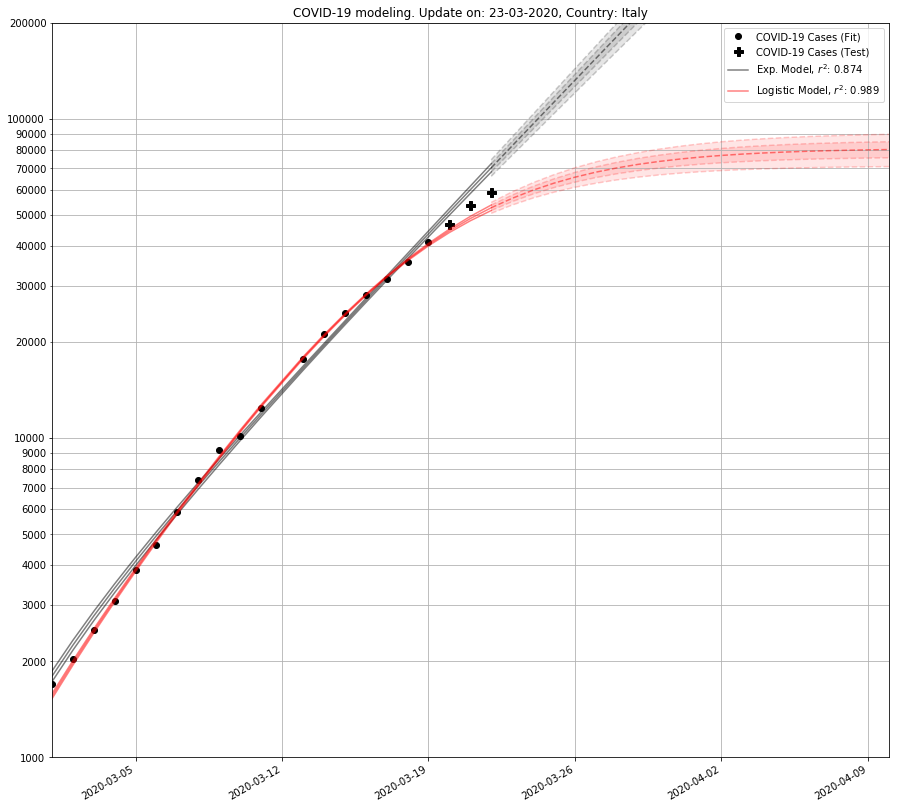

In [8]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 200000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

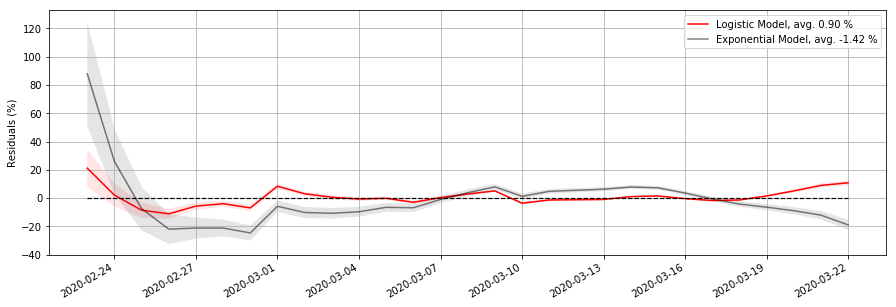

In [9]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()

## Logistic model: forecast 30 days ahead

In [10]:
display(df_forecast_logit)

,Date,Forecast,1s_sup,1s_inf,2s_sup,2s_inf,Uncertainty
28,2020-03-22,52694.649981,53737.342429,51651.957532,54780.034877,50609.265084,1042.692448
29,2020-03-23,56409.803801,57752.384622,55067.222980,59094.965443,53724.642158,1342.580821
30,2020-03-24,59832.338170,61493.368956,58171.307384,63154.399743,56510.276598,1661.030786
31,2020-03-25,62930.582644,64916.980769,60944.184520,66903.378893,58957.786396,1986.398124
32,2020-03-26,65691.129511,67999.158360,63383.100663,70307.187208,61075.071814,2308.028848
33,2020-03-27,68116.240788,70733.297086,65499.184490,73350.353384,62882.128192,2617.056298
34,2020-03-28,70220.344432,73127.160526,67313.528337,76033.976621,64406.712243,2906.816094
35,2020-03-29,72026.322965,75199.223531,68853.422399,78372.124097,65680.521834,3172.900566
36,2020-03-30,73562.104636,76975.051932,70149.157340,80387.999228,66736.210043,3412.947296
37,2020-03-31,74857.845536,78484.123555,71231.567517,82110.401573,67605.289498,3626.278019


## Fit stability
### Logistic model

In [11]:
#dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
#dfit = dfit.loc[dfit['Cases'] > 10]

#dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

#ydata=dfit['Cases'] 
#xdata=dfit['ndays']

#p0=popt
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]

fit_stab = []

for i in range(len(xdata))[::-1]:
    
    if i != 0:
        
        ipopt, ipcov, irsquare = fit_model(xdata[:i],ydata[:i],logistic_model, p0=p0)
        fit_stab.append({
            'x': xdata.iloc[i],
            'date' : dfit['Date'].iloc[i],
            'popt' : ipopt, 
            'perr' : np.sqrt(np.diag(ipcov)), 
            'r_square' : irsquare
        })

In [12]:
df=pd.DataFrame(fit_stab)

tmp_1=df.date.apply(pd.Series)
tmp_1.columns=['date']
tmp_2=df.popt.apply(pd.Series)
tmp_2.columns=['popt_0', 'popt_1', 'popt_2', 'popt_3']
tmp_3=df.perr.apply(pd.Series)
tmp_3.columns=['perr_0', 'perr_1', 'perr_2', 'perr_3']

df = pd.concat([tmp_1, tmp_2, tmp_3, df.r_square], axis=1)

df = df.sort_values(by='date').reset_index(drop=True)

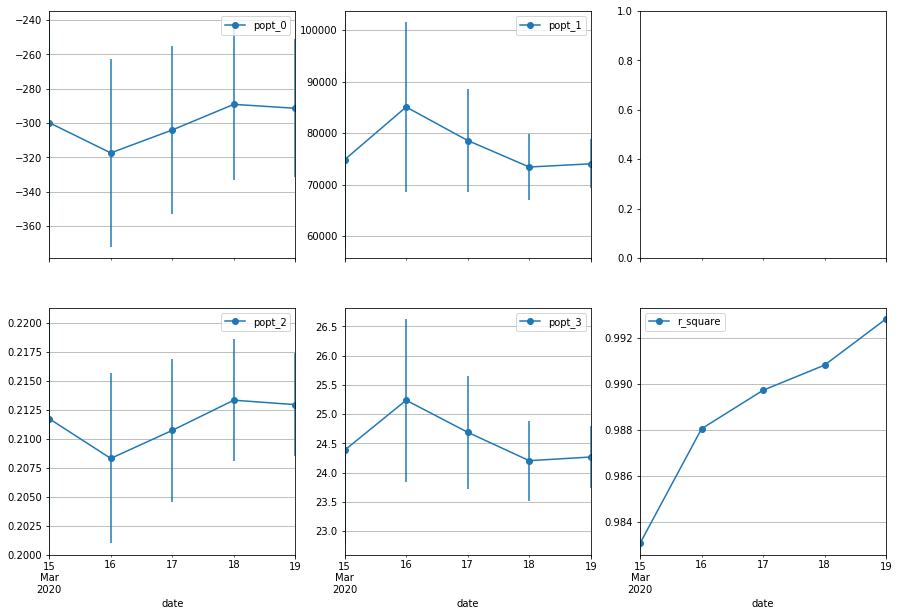

In [13]:
f, ax = plt.subplots(2, 3, sharex=True, figsize=(15,10))

df[-5:].plot(x='date', y='popt_0', yerr='perr_0', marker='o', grid=True, ax=ax[0][0])
df[-5:].plot(x='date', y='popt_1', yerr='perr_1', marker='o', grid=True, ax=ax[0][1])
df[-5:].plot(x='date', y='popt_2', yerr='perr_2', marker='o', grid=True, ax=ax[1][0])
df[-5:].plot(x='date', y='popt_3', yerr='perr_3', marker='o', grid=True, ax=ax[1][1])
df[-5:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][2])

#plt.xlabel('')

plt.show()

### Exponential model

In [14]:
#dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
#dfit = dfit.loc[dfit['Cases'] > 10]

#dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

#ydata=dfit['Cases'] 
#xdata=dfit['ndays']

p0=[-4.76730302e+02,1.72669390e-01,6.13355554e+00]

fit_stab = []

for i in range(len(xdata)):#[::-1]:
    
    if i != 0:
            
        ipopt, ipcov, irsquare = fit_model(xdata[:i],ydata[:i],exponential_model, p0=p0)
        fit_stab.append({
            'x': xdata.iloc[i],
            'date' : dfit['Date'].iloc[i],
            'popt' : ipopt, 
            'perr' : np.sqrt(np.diag(ipcov)), 
            'r_square' : irsquare
        })

In [15]:
df=pd.DataFrame(fit_stab)

tmp_1=df.date.apply(pd.Series)
tmp_1.columns=['date']
tmp_2=df.popt.apply(pd.Series)
tmp_2.columns=['popt_0', 'popt_1', 'popt_2']
tmp_3=df.perr.apply(pd.Series)
tmp_3.columns=['perr_0', 'perr_1', 'perr_2']

df = pd.concat([tmp_1, tmp_2, tmp_3, df.r_square], axis=1)

df = df.sort_values(by='date').reset_index(drop=True)

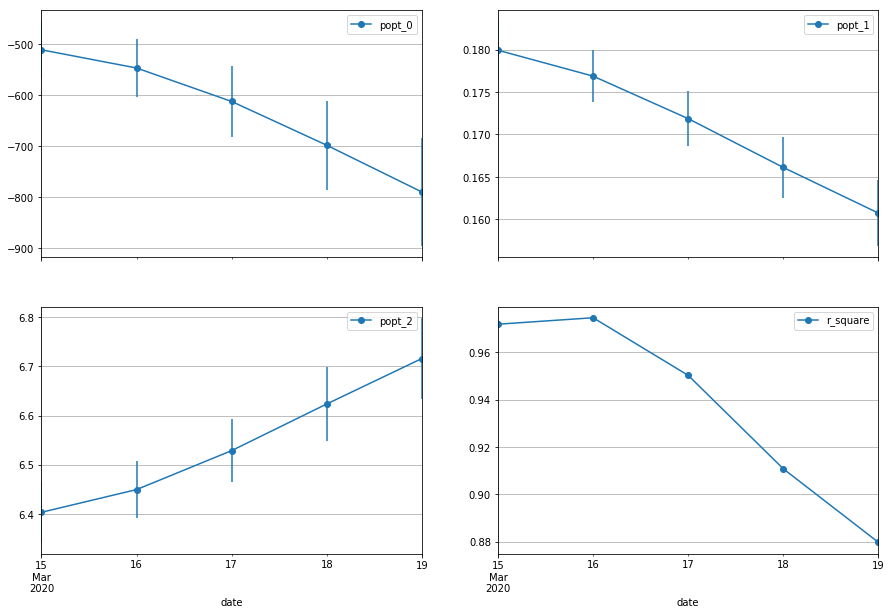

In [16]:
f, ax = plt.subplots(2, 2, sharex=True, figsize=(15,10))

df[-5:].plot(x='date', y='popt_0', yerr='perr_0', marker='o', grid=True, ax=ax[0][0])
df[-5:].plot(x='date', y='popt_1', yerr='perr_1', marker='o', grid=True, ax=ax[0][1])
df[-5:].plot(x='date', y='popt_2', yerr='perr_2', marker='o', grid=True, ax=ax[1][0])
df[-5:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][1])

#plt.xlabel('')

plt.show()

# Fit data for France

In [17]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'France'].reset_index(drop=True)

# Drop 15/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(52, axis=0)

dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[ 0.50341354,  0.5, -0.6697555 ]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-3.06625148e+02  1.90674561e-01  5.93072071e+00]

Parameter errors:
[6.86781481e+01 7.26770743e-03 1.21183189e-01]

Covariance matrix:
[[ 4.71668802e+03  4.52357385e-01 -7.78241389e+00]
 [ 4.52357385e-01  5.28195713e-05 -8.68887736e-04]
 [-7.78241389e+00 -8.68887736e-04  1.46853652e-02]]

R-square: 0.947

-----------------
Logistic model
-----------------

Fit Parameters:
[-8.53983299e+01  2.23791954e+04  2.59420764e-01  1.82713668e+01]

Parameter errors:
[5.26921250e+01 4.23023461e+03 1.74929900e-02 1.28221335e+00]

Covariance matrix:
[[ 2.77646004e+03 -1.67794488e+05  8.23901163e-01 -5.19022816e+01]
 [-1.67794488e+05  1.78948848e+07 -6.92498668e+01  5.40384095e+03]
 [ 8.23901163e-01 -6.92498668e+01  3.06004698e-04 -2.13843324e-02]
 [-5.19022816e+01  5.40384095e+03 -2.13843324e-02  1.64407108e+00]]

R-square: 0.982


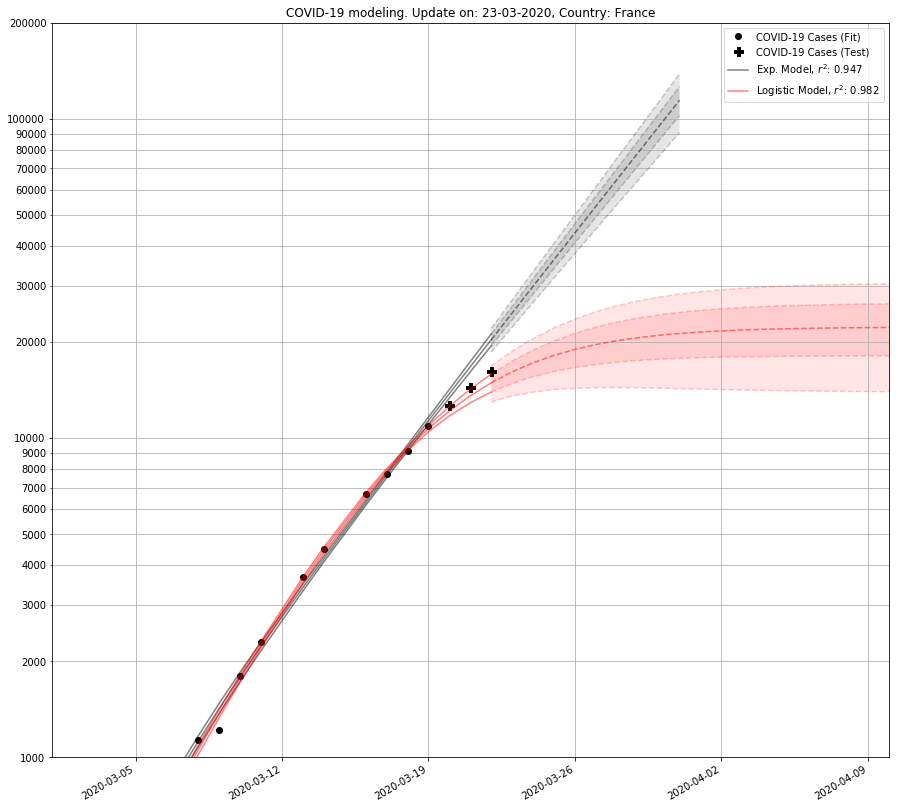

In [18]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 200000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

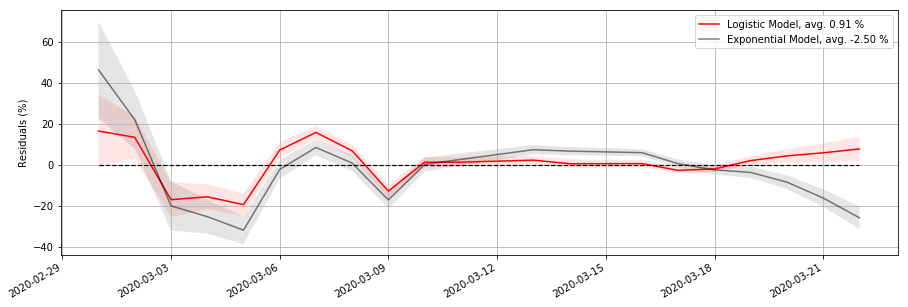

In [19]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()

# Fit data for Switzerland

In [20]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Switzerland'].reset_index(drop=True)

# Drop 16/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(53, axis=0)

dfit = dfit.loc[dfit['Cases'] > 10]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[ 0.50341354,  0.5, -0.6697555 ]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-62.14742216   0.21507846   4.2482038 ]

Parameter errors:
[1.85134609e+01 9.37789866e-03 1.60423985e-01]

Covariance matrix:
[[ 3.42748236e+02  1.49463884e-01 -2.64641510e+00]
 [ 1.49463884e-01  8.79449833e-05 -1.48150976e-03]
 [-2.64641510e+00 -1.48150976e-03  2.57358550e-02]]

R-square: 0.764

-----------------
Logistic model
-----------------

Fit Parameters:
[-2.21491617e+01  8.94379758e+03  2.73470861e-01  1.99334311e+01]

Parameter errors:
[1.88004792e+01 3.20178480e+03 2.74675777e-02 2.21150076e+00]

Covariance matrix:
[[ 3.53458017e+02 -4.33192988e+04  4.47956581e-01 -3.09353473e+01]
 [-4.33192988e+04  1.02514259e+07 -8.14391303e+01  7.04910519e+03]
 [ 4.47956581e-01 -8.14391303e+01  7.54467823e-04 -5.77128438e-02]
 [-3.09353473e+01  7.04910519e+03 -5.77128438e-02  4.89073560e+00]]

R-square: 0.810


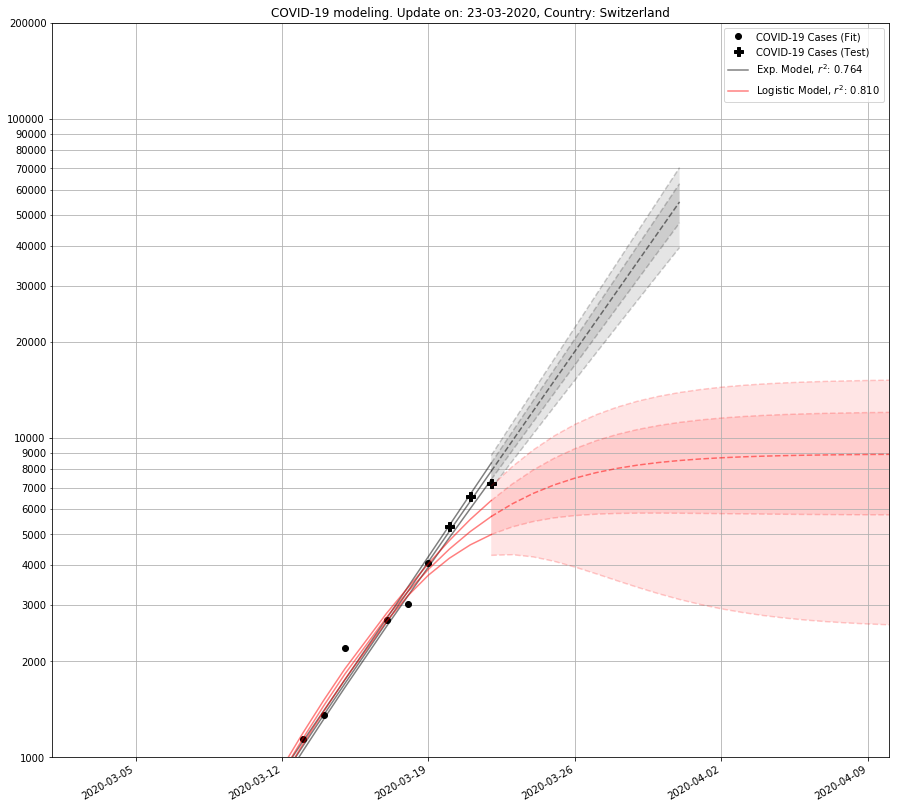

In [21]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 200000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

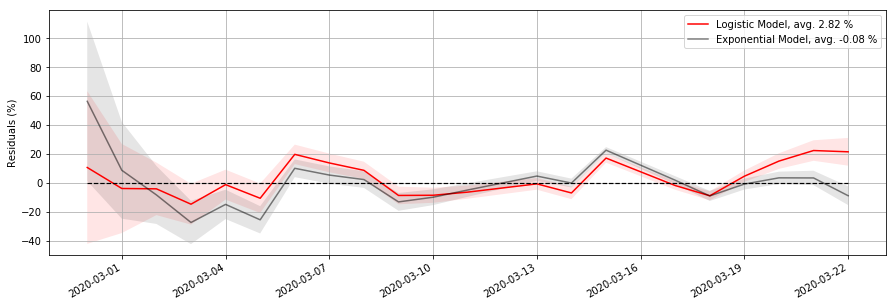

In [22]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()